# Evaluation


In [7]:
import h5py
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams

from tqdne.config import SpectrogramClassificationConfig
from tqdne.metric import AmplitudeSpectralDensity, frechet_distance
from tqdne.plot import BinPlot, MovingAverageEnvelopeGrid, AmplitudeSpectralDensityGrid
from tqdne.plot import AmplitudeSpectralDensity as ASDPlot

## Setup

In [8]:
config = SpectrogramClassificationConfig()
mag_bins = config.mag_bins
dist_bins = config.dist_bins

evaluation_dir = config.outputdir / "evaluation-Latent-EDM-LogSpectrogram"
full = h5py.File(evaluation_dir / "full.h5", "r")
train = h5py.File(evaluation_dir / "train.h5", "r")
test = h5py.File(evaluation_dir / "test.h5", "r")


# Matplotlib settings
rcParams["font.family"] = "serif"
rcParams["text.usetex"] = False
rcParams["font.size"] = 16

## Data distribution
Create the plot for the binning of the data and the heatmap for the number of samples in each bin.

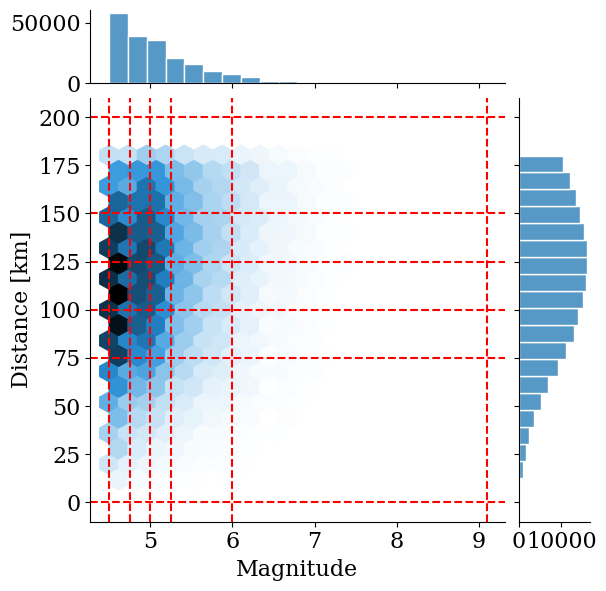

In [10]:
mag = full["magnitude"][:]
dist = full["hypocentral_distance"][:]

fig = sns.jointplot(
    x=mag,
    y=dist,
    kind="hex",
    marginal_ticks=True,
    joint_kws=dict(gridsize=20),
    marginal_kws=dict(bins=20, edgecolor="white"),
)
# plot.figure.set_size_inches([fig_width, fig_width])
plt.xlabel("Magnitude")
plt.ylabel("Distance [km]")

# draw bins
for x in mag_bins:
    plt.axvline(x, color="red", linestyle="--")
for y in dist_bins:
    plt.axhline(y, color="red", linestyle="--")

fig.savefig("../figures/binning.pdf")

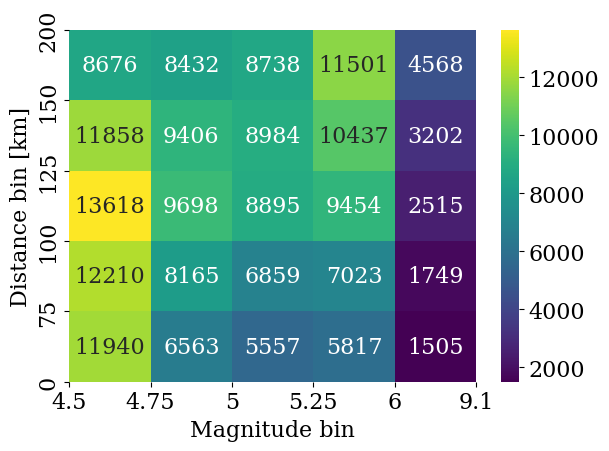

In [11]:
size_metric = lambda x, *args, **kwargs: len(x)
fig = BinPlot(metric=size_metric, mag_bins=mag_bins, dist_bins=dist_bins, fmt="d")(
    pred=mag, target=mag, mag=mag, dist=dist
)
fig.savefig("../figures/class_distribution.pdf")

## Embedding Frechet Distance (FID)

In [4]:
print(
    f"Generated vs Real: {round(frechet_distance(full['predicted_classifier_embedding'][:], full['target_classifier_embedding'][:], isotropic=True), 2)}"
)

print(
    f"Generated vs Test: {round(frechet_distance(test['predicted_classifier_embedding'][:], test['target_classifier_embedding'][:], isotropic=True), 2)}"
)

print(
    f"Train vs Test: {round(frechet_distance(train['target_classifier_embedding'][:], test['target_classifier_embedding'][:], isotropic=True), 2)}"
)

Generated vs Real: 3.390000104904175
Generated vs Test: 3.309999942779541
Train vs Test: 0.05999999865889549


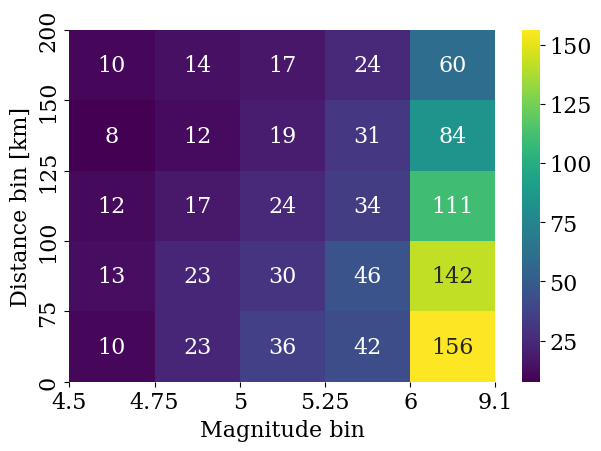

In [16]:
fid_metric = lambda x, y: frechet_distance(x, y, isotropic=False)
fig = BinPlot(metric=fid_metric, mag_bins=mag_bins, dist_bins=dist_bins, fmt=".0f")(
    pred=full["predicted_classifier_embedding"][:],
    target=full["target_classifier_embedding"][:],
    mag=full["magnitude"][:],
    dist=full["hypocentral_distance"][:],
)
fig.savefig("../figures/embedding_fd_heatmap.pdf")

## Classifier Accuracy

In [17]:
def get_label(mag, dist):
    return (np.digitize(dist, dist_bins) - 1) * (len(mag_bins) - 1) + np.digitize(mag, mag_bins) - 1


def accuracy(logits, labels):
    return (logits.argmax(axis=-1) == labels).mean() * 100

In [24]:
print(
    f"Generated Full: {round(accuracy(full['predicted_classifier_pred'][:], get_label(full['magnitude'][:], full['hypocentral_distance'][:])), 2)} %"
)
print(
    f"Generated Test: {round(accuracy(test['predicted_classifier_pred'][:], get_label(test['magnitude'][:], test['hypocentral_distance'][:])), 2)} %"
)
print(
    f"Test: {round(accuracy(test['target_classifier_pred'][:], get_label(test['magnitude'][:], test['hypocentral_distance'][:])), 2)} %"
)

Generated Full: 44.48 %
Generated Test: 44.48 %
Test: 57.67 %


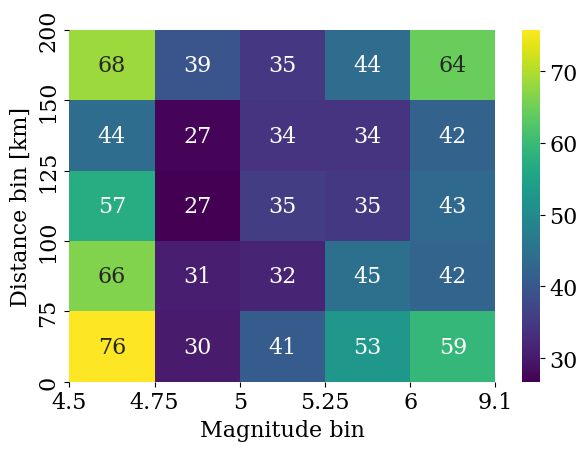

In [12]:
fig = BinPlot(metric=accuracy, mag_bins=mag_bins, dist_bins=dist_bins, fmt=".0f")(
    pred=full["predicted_classifier_pred"][:],
    target=get_label(
        full["magnitude"][:], full["hypocentral_distance"][:]
    ),  # missusing target for labels
    mag=full["magnitude"][:],
    dist=full["hypocentral_distance"][:],
)
fig.savefig("../figures/accuracy_heatmap.pdf")

## Amplitude Spectral Density

In [3]:
print(
    f"Channel 0: Generated vs Real: {round(AmplitudeSpectralDensity(100, 0)(full['predicted_waveform'][:], full['target_waveform'][:]), 2)}"
)

print(
    f"Channel 0: Generated vs Test: {round(AmplitudeSpectralDensity(100, 0)(test['predicted_waveform'][:], test['target_waveform'][:]), 2)}"
)

print(
    f"Channel 0: Train vs Test: {round(AmplitudeSpectralDensity(100, 0)(train['target_waveform'][:], test['target_waveform'][:]), 2)}"
)

print()

print(
    f"Channel 1: Generated vs Real: {round(AmplitudeSpectralDensity(100, 1)(full['predicted_waveform'][:], full['target_waveform'][:]), 2)}"
)

print(
    f"Channel 1: Generated vs Test: {round(AmplitudeSpectralDensity(100, 1)(test['predicted_waveform'][:], test['target_waveform'][:]), 2)}"
)

print(
    f"Channel 1: Train vs Test: {round(AmplitudeSpectralDensity(100, 1)(train['target_waveform'][:], test['target_waveform'][:]), 2)}"
)

print()

print(
    f"Channel 2: Generated vs Real: {round(AmplitudeSpectralDensity(100, 2)(full['predicted_waveform'][:], full['target_waveform'][:]), 2)}"
)

print(
    f"Channel 2: Generated vs Test: {round(AmplitudeSpectralDensity(100, 2)(test['predicted_waveform'][:], test['target_waveform'][:]), 2)}"
)

print(
    f"Channel 2: Train vs Test: {round(AmplitudeSpectralDensity(100, 2)(train['target_waveform'][:], test['target_waveform'][:]), 2)}"
)

Channel 0: Generated vs Real: 60.98
Channel 0: Generated vs Test: 66.61
Channel 0: Train vs Test: 0.22

Channel 1: Generated vs Real: 47.84
Channel 1: Generated vs Test: 52.34
Channel 1: Train vs Test: 0.2

Channel 2: Generated vs Real: 56.73
Channel 2: Generated vs Test: 60.18
Channel 2: Train vs Test: 0.24


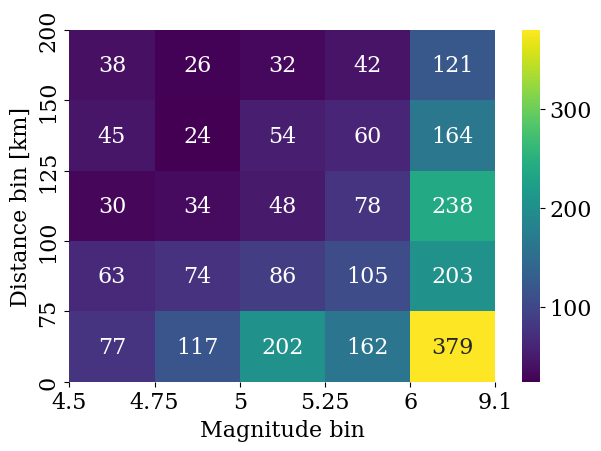

In [13]:
fig = BinPlot(metric=AmplitudeSpectralDensity(100, 0, isotropic=True), mag_bins=mag_bins, dist_bins=dist_bins, fmt=".0f")(
    pred=full["predicted_waveform"][:],
    target=full["target_waveform"][:],
    mag=full["magnitude"][:],
    dist=full["hypocentral_distance"][:],
)
fig.savefig("../figures/asd_heatmap_0.pdf")

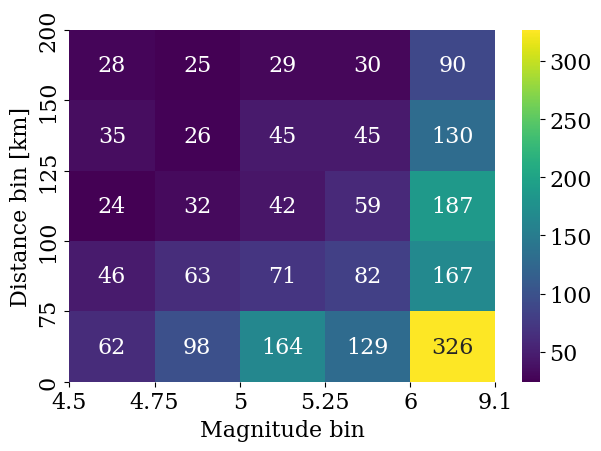

In [14]:
fig = BinPlot(metric=AmplitudeSpectralDensity(100, 1, isotropic=True), mag_bins=mag_bins, dist_bins=dist_bins, fmt=".0f")(
    pred=full["predicted_waveform"][:],
    target=full["target_waveform"][:],
    mag=full["magnitude"][:],
    dist=full["hypocentral_distance"][:],
)
fig.savefig("../figures/asd_heatmap_1.pdf")

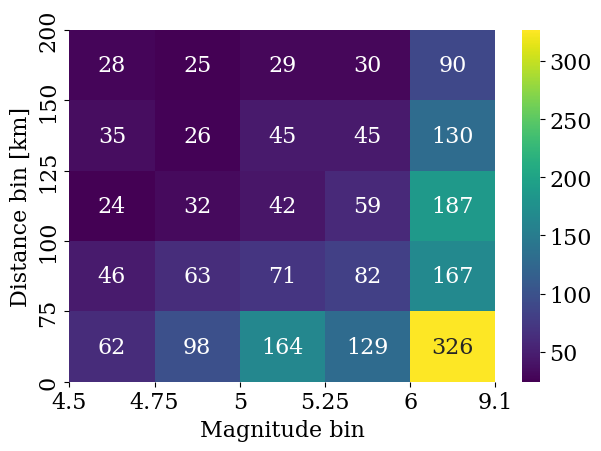

In [15]:
fig = BinPlot(metric=AmplitudeSpectralDensity(100, 1, isotropic=True), mag_bins=mag_bins, dist_bins=dist_bins, fmt=".0f")(
    pred=full["predicted_waveform"][:],
    target=full["target_waveform"][:],
    mag=full["magnitude"][:],
    dist=full["hypocentral_distance"][:],
)
fig.savefig("../figures/asd_heatmap_2.pdf")

## Grid plot

In [4]:
distance_bins = [0, 40, 60, 80, 120, 150, 200]
magnitude_bins = [4.5, 5.0, 5.5, 6.0, 7.0, 9.0]

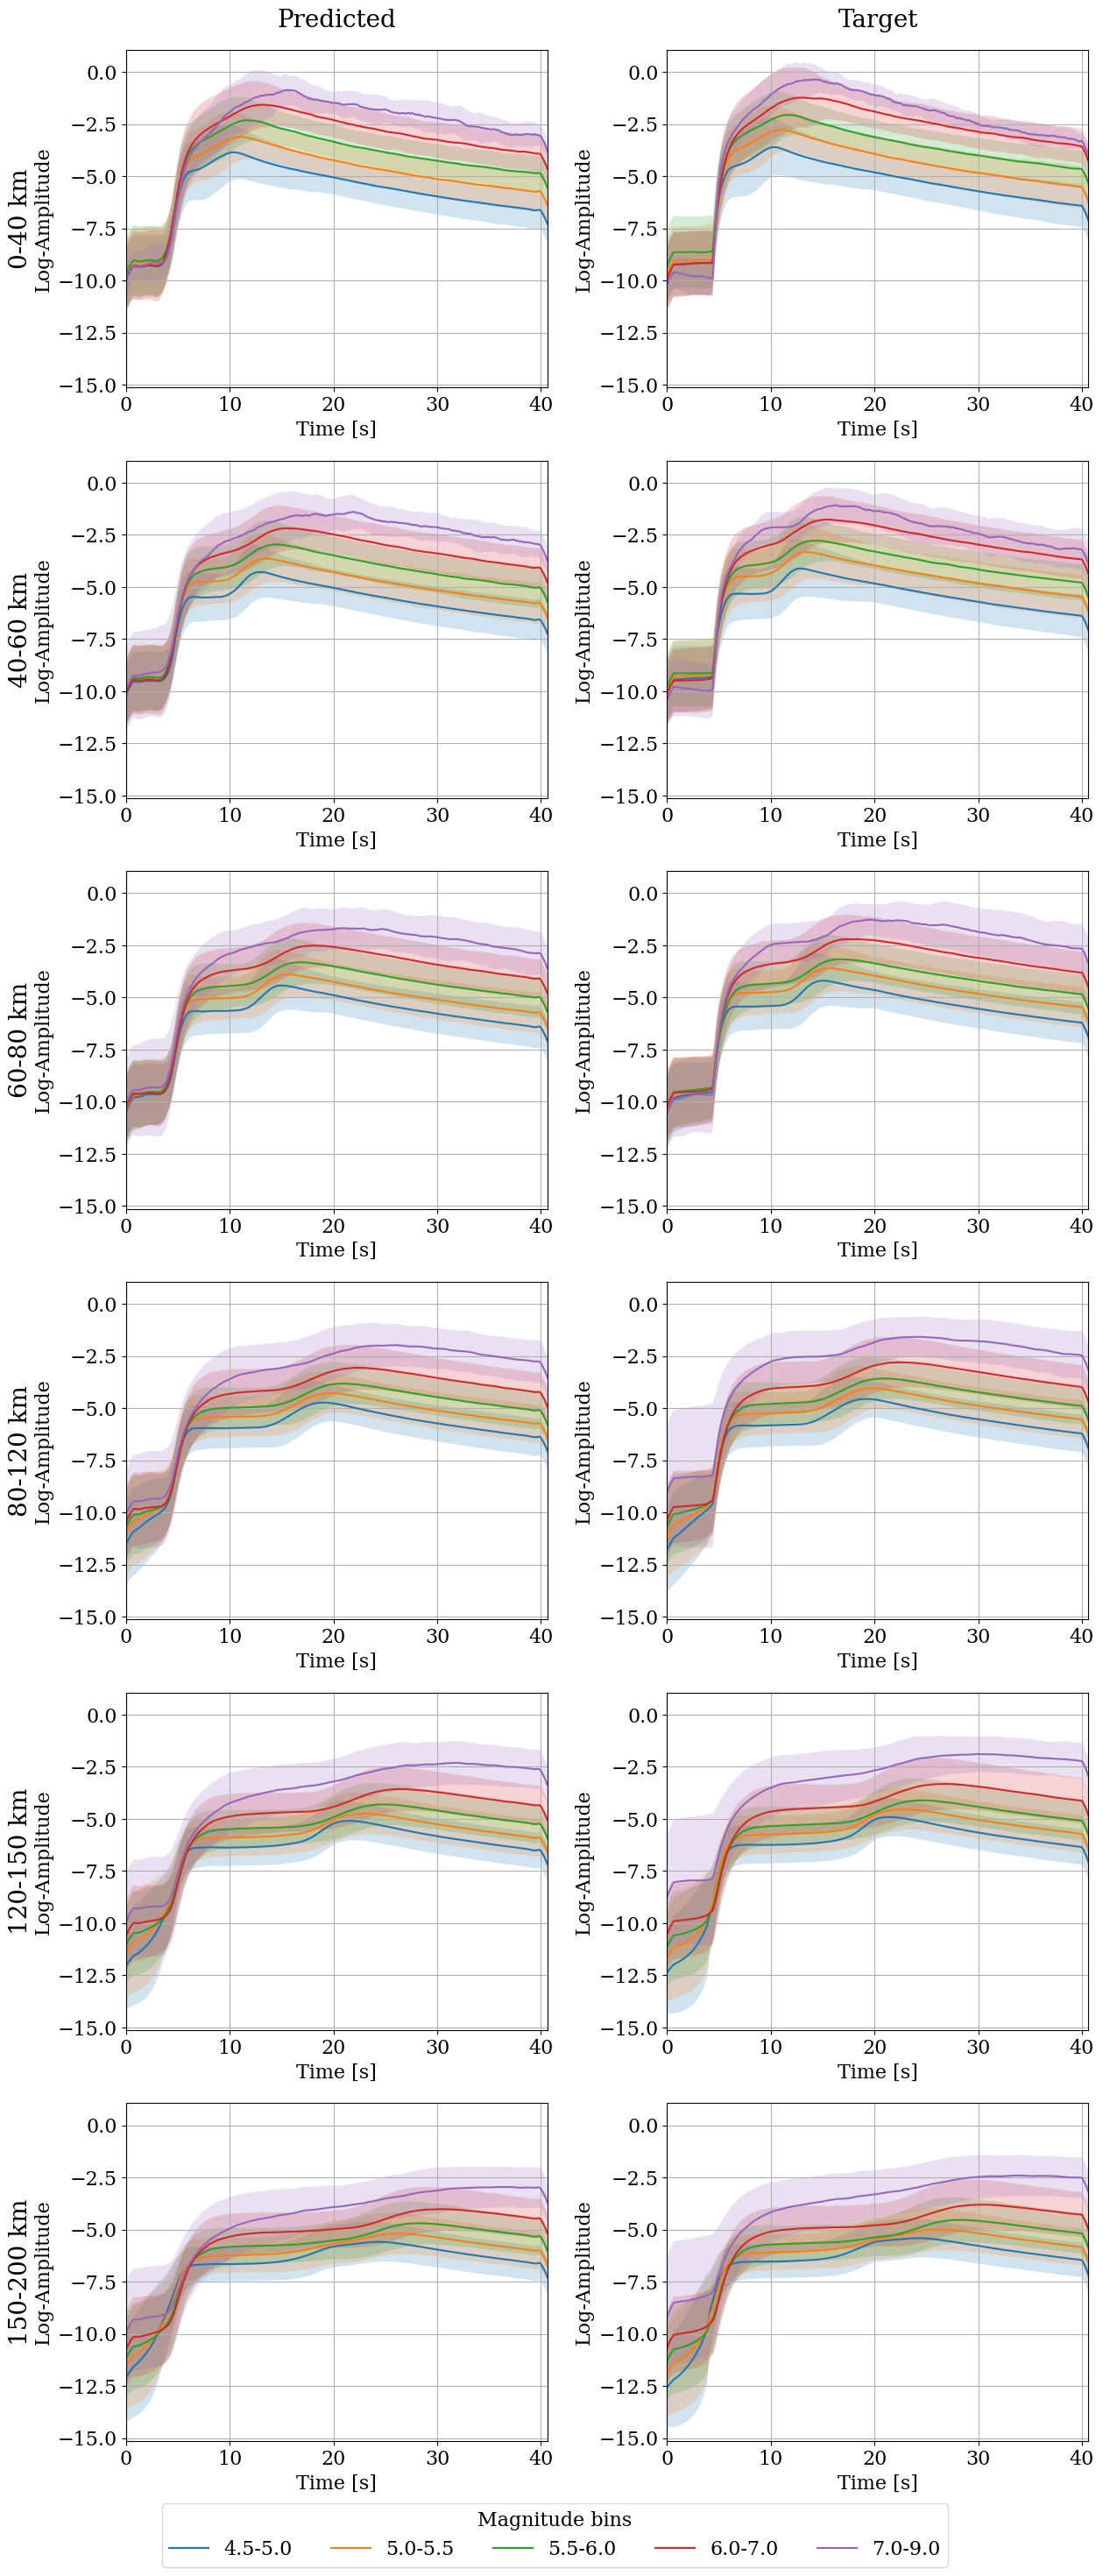

In [10]:
fig = MovingAverageEnvelopeGrid(fs=config.fs, channel=0, mag_bins=magnitude_bins, dist_bins=distance_bins)(
    pred=full["predicted_waveform"][:],
    target=full["target_waveform"][:],
    mag=full["magnitude"][:],
    dist=full["hypocentral_distance"][:],
)
fig.savefig("../figures/moving_average_envelope_grid.pdf")

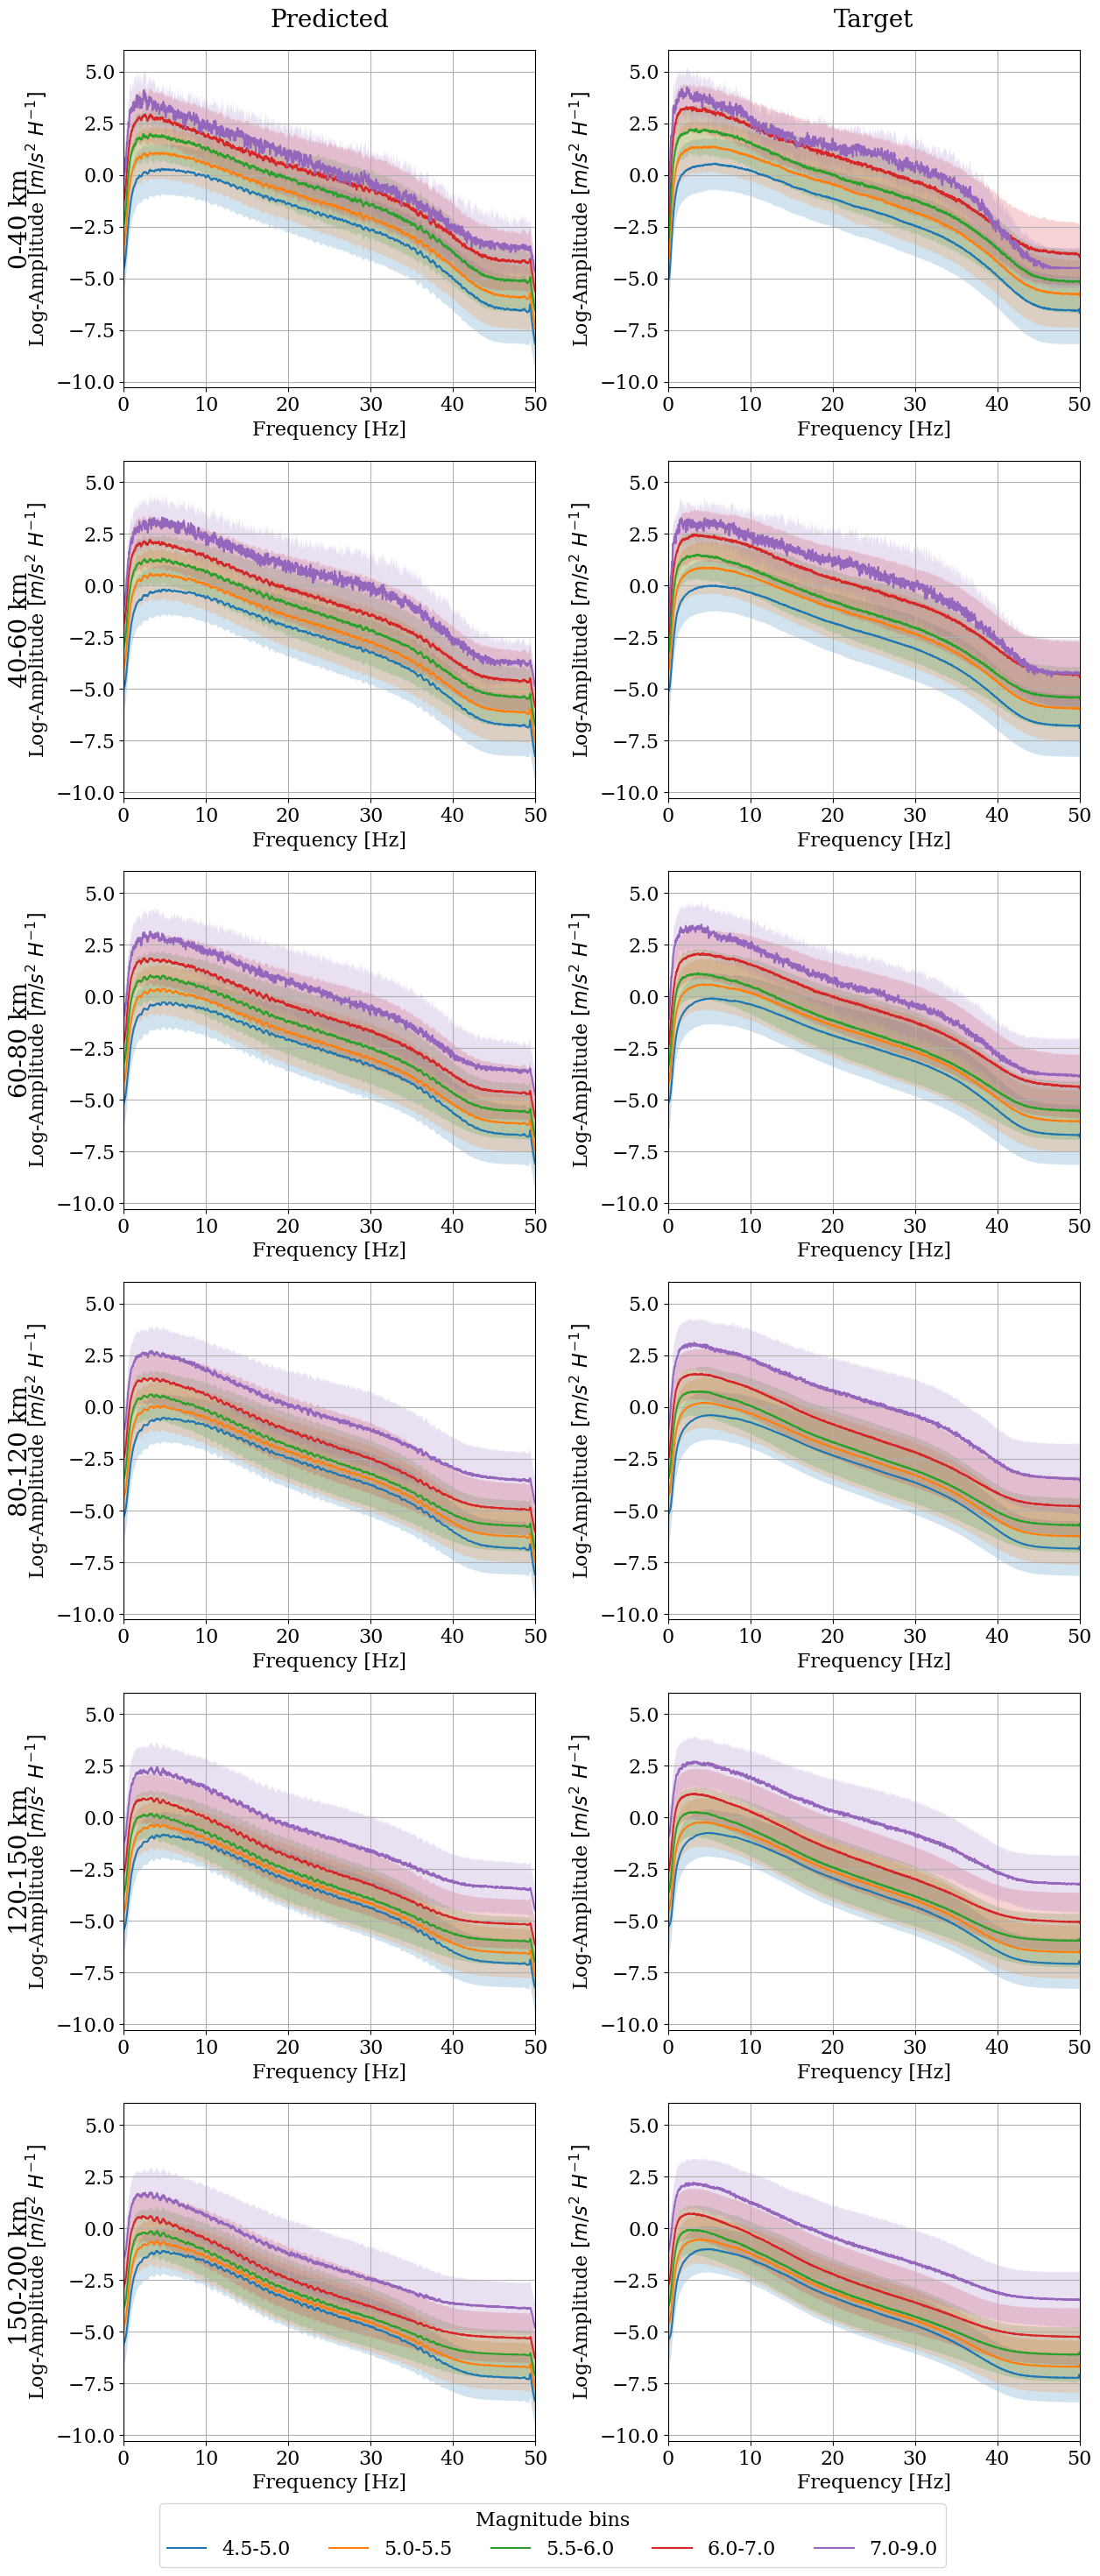

In [9]:
fig = AmplitudeSpectralDensityGrid(fs=config.fs, channel=0, mag_bins=magnitude_bins, dist_bins=distance_bins)(
    pred=full["predicted_waveform"][:],
    target=full["target_waveform"][:],
    mag=full["magnitude"][:],
    dist=full["hypocentral_distance"][:],
)
fig.savefig("../figures/asd_grid.pdf")